> Reference: Adversarial Attacks with Carlini & Wagner Approach: https://medium.com/@zachariaharungeorge/adversarial-attacks-with-carlini-wagner-approach-8307daa9a503

# Formulating the C&W Attack as an Optimization Problem

The Carlini & Wagner (C&W) attack formulates the generation of adversarial examples as an optimization problem, seeking to find the smallest perturbation to the input data that causes a misclassification by the target model. This optimization problem is crafted to balance the imperceptibility of the perturbation with the effectiveness of inducing misclassification. Let's delve deeper into the formulation of the C&W attack:

## 1. Defining the Objective Function

The C&W attack begins by defining an objective function, $J(x')$, that quantifies the goals of the attack.

$$
J(x') = \alpha \cdot \text{dist}(x, x') + \beta \cdot \text{loss}(f(x'), y_t)
$$

where:
- $x$ is the original input.
- $x'$ is the perturbed input.
- $\text{dist}(x, x')$ measures the perturbation, typically using the L2 or L∞ norm.
- $\text{loss}(f(x'), y_t)$ represents the misclassification loss of the target model $f$ on the perturbed input with respect to the target class $y_t$.
- $\alpha$ and $\beta$ are weights that balance the two objectives.

The objectives are:
- **Minimizing the perturbation:** To ensure that the adversarial example remains visually similar to the original input.
- **Maximizing the misclassification confidence:** To guarantee that the perturbed input is misclassified by the target model.

## 2. Optimization Algorithm

The C&W attack is an iterative process that refines the adversarial example through multiple iterations. The optimization algorithm adjusts the perturbation to improve the chances of misclassification while keeping the perturbation imperceptible.

**Gradient Descent:** This common optimization algorithm uses the gradients of the objective function with respect to the input, adjusting the input in the opposite direction of these gradients. This process is repeated iteratively to converge towards an adversarial example.

$$
x'_n = x' - \eta \cdot \nabla_{x'} J(x')
$$

where $\eta$ is the step size, determining the magnitude of adjustments.

## 3. Balancing Trade-offs

**Trade-off Parameter Tuning:** The weights $\alpha$ and $\beta$ in the objective function determine the trade-off between minimizing perturbation and maximizing misclassification. Tuning these parameters allows for emphasis on one aspect over the other based on specific requirements of the attack.

## 4. Adaptability to Threat Models

The optimization problem is tailored to different threat models by considering different norms, such as the L2 norm (Euclidean distance) or the L∞ norm (maximum perturbation). This adaptability allows the C&W attack to address a variety of scenarios and evaluation criteria.

For example:
- For the L2 norm: $\text{dist}(x, x') = \|x - x'\|_2$
- For the L∞ norm: $\text{dist}(x, x') = \max(\|x - x'\|_\infty - \epsilon, 0)$, where $\epsilon$ is a constraint on the maximum perturbation.

## 5. Handling Model Uncertainties

To counter gradient masking, where models intentionally obscure their gradients, the C&W attack incorporates strategies such as randomization during optimization. This introduces an element of uncertainty into the gradient computation process.

$$
\nabla_{x'} J(x') = \nabla_{x'} J(x') + \text{random noise}
$$

Introducing random noise ensures that the gradient estimation remains resilient even when the model attempts to hide its true gradients.



In [ ]:
! pip install ultralytics

In [21]:
import torch
import torch.nn as nn
from ultralytics import YOLO
from torchvision import transforms
from PIL import Image



# Step 1: Load trained YOLOv8 model
model = YOLO('train/weights/best.pt')
image_path = 'stop.png'

# Step 2: Extract the backbone (CSPDarknet53)
backbone = model.model.model[:10]
labels = torch.tensor([22])

num_classes = 29
sample_image = torch.randn(1, 3, 416, 416)  # Adjust size if necessary
sample_output = backbone(sample_image)
output_channels = sample_output.shape[1]
classify_model = nn.Sequential(
    backbone,  # Use the CSPDarknet53 backbone
    nn.AdaptiveAvgPool2d((1, 1)),  # Global Average Pooling to reduce to (batch_size, channels, 1, 1)
    nn.Flatten(),  # Flatten to (batch_size, channels)
    nn.Linear(in_features=output_channels, out_features=num_classes)  # Linear layer for classification
)

preprocess = transforms.Compose([
    transforms.Resize((416, 416)),  # Resize to 416x416
    transforms.ToTensor(),          # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

image = Image.open(image_path).convert("RGB")  # Load image and ensure it's in RGB format
image = preprocess(image).unsqueeze(0)  # Apply preprocessing and add batch dimension

Implement Carlini & Wagner (C&W) Attack here.

In [22]:
import torch.optim as optim
import torch

# Carlini & Wagner (C&W) Attack Implementation
def cw_attack(model, images, labels, targeted=True, c=1e-4, kappa=0, lr=0.01, max_iter=1000):
    # Ensure the model is in evaluation mode
    model.eval()
    
    # Initialize perturbed image as a tensor with requires_grad=True
    perturbed_image = images.clone().detach().requires_grad_(True)
    
    # Define optimizer for the perturbed image
    optimizer = optim.Adam([perturbed_image], lr=lr)
    
    # Iterative optimization process
    for i in range(max_iter):
        optimizer.zero_grad()
        outputs = model(perturbed_image)
        
        # Calculate loss for targeted or untargeted attack
        if targeted:
            target_labels = labels  # Assuming labels are the target class
            loss = torch.clamp(outputs[:, target_labels] - torch.max(outputs[:, torch.arange(outputs.size(1)) != target_labels]), min=-kappa)
            loss = c * loss.sum()
        else:
            correct_class = labels
            loss = torch.clamp(torch.max(outputs[:, torch.arange(outputs.size(1)) != correct_class]) - outputs[:, correct_class], min=-kappa)
            loss = c * loss.sum()
        
        # Calculate L2 distance (perturbation magnitude)
        l2_dist = torch.sum((perturbed_image - images) ** 2)
        
        # Total loss combines L2 distance and misclassification loss
        total_loss = l2_dist + loss
        
        # Backpropagate to calculate gradients
        total_loss.backward()
        
        # Update the perturbed image
        optimizer.step()
        
        # Clip perturbed image to maintain valid pixel range
        perturbed_image.data = torch.clamp(perturbed_image.data, 0, 1)
    
    # Normalize the perturbation to avoid potential invalid values
    perturbation = perturbed_image - images
    perturbation = (perturbation - perturbation.min()) / (perturbation.max() - perturbation.min() + 1e-8)
    perturbed_image = images + perturbation
    
    return perturbed_image.detach()

# Example usage of C&W attack
perturbed_image_cw = cw_attack(classify_model, image, labels, targeted=True, c=1e-4, kappa=0, lr=0.01, max_iter=1000)
# perturbed_image_cw = cw_attack(classify_model, image, labels, targeted=True, c=1e-4, kappa=1, lr=0.02, max_iter=1000)






In [23]:
def get_yolo_output(model, image):
    results = model(image)
    return results[0].boxes.xyxy, results[0].boxes.conf, results[0].boxes.cls

# Clamp the image values to be between 0 and 1
perturbed_image_cw = torch.clamp(perturbed_image_cw, 0, 1)

image = torch.clamp(image, 0, 1)
boxes, scores, labels = get_yolo_output(model, image)

# Get YOLO output for the perturbed image from C&W attack
perturbed_boxes_cw, perturbed_scores_cw, perturbed_labels_cw = get_yolo_output(model, perturbed_image_cw)



0: 416x416 1 Stop_Sign, 72.0ms
Speed: 0.0ms preprocess, 72.0ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)

0: 416x416 1 Stop_Sign, 66.3ms
Speed: 0.0ms preprocess, 66.3ms inference, 1.7ms postprocess per image at shape (1, 3, 416, 416)


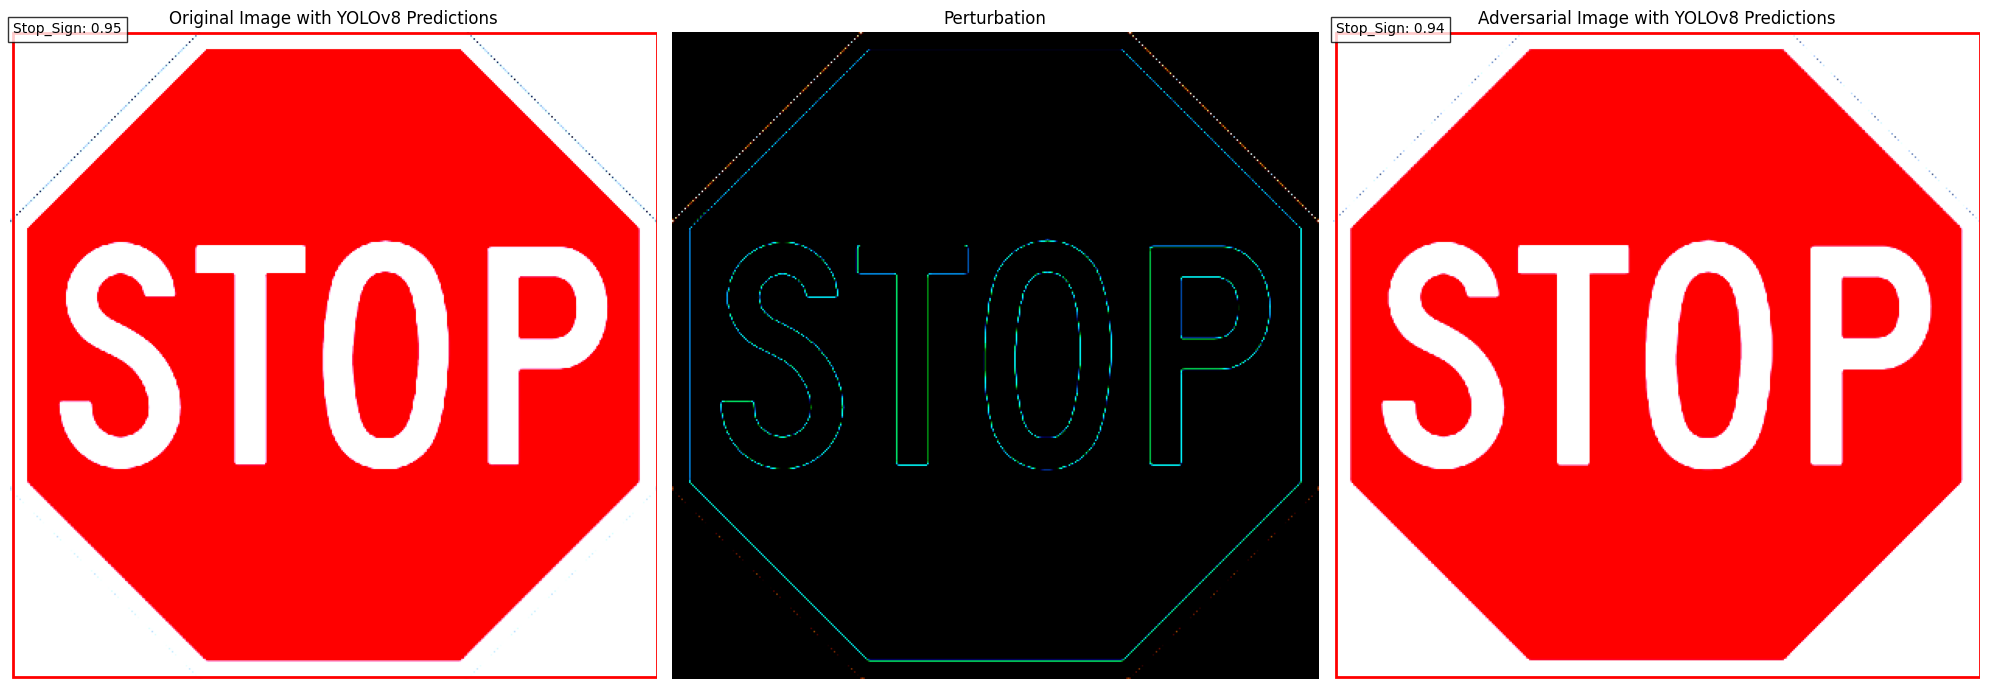

In [25]:
import matplotlib.pyplot as plt

def plot_boxes(ax, boxes, scores, labels, title, image_tensor):
    # Detach, remove batch dimension, permute to (height, width, channels), and convert to NumPy
    ax.imshow(image_tensor.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box.detach().cpu().numpy()
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='r', linewidth=2)
        ax.add_patch(rect)
        ax.text(x1, y1, f"{model.names[int(label)]}: {score:.2f}", bbox=dict(facecolor='white', alpha=0.8))
    ax.set_title(title)
    ax.axis('off')

fig, axs = plt.subplots(1, 3, figsize=(20, 10))

# Original image with predictions
plot_boxes(axs[0], boxes, scores, labels, "Original Image with YOLOv8 Predictions", image)

# Perturbation
perturbation = (perturbed_image_cw - image).squeeze().permute(1, 2, 0).cpu().detach().numpy()
perturbation = (perturbation - perturbation.min()) / (perturbation.max() - perturbation.min())
axs[1].imshow(perturbation)
axs[1].set_title("Perturbation")
axs[1].axis('off')

# Adversarial image with predictions
plot_boxes(axs[2], perturbed_boxes_cw, perturbed_scores_cw, perturbed_labels_cw, "Adversarial Image with YOLOv8 Predictions", perturbed_image_cw)

plt.tight_layout()
plt.show()
